# Lecture 8 - Time Series Analysis

In this notebook we will learn how to perform time series analysis of Twitter data. 

<ol type = 1>
<li> Data processing</li>
    <ol type = a>
    <li> Load users' tweets</li>
    <li> Convert tweet times into datetime objects</li>
    <li> Shift times of tweets</li>
    </ol>
<li> Tweet rate</li>
    <ol type = a>
    <li> Calculate mean tweet rate</li>
    <li> Calculate rolling average tweet rate</li>
        <li> Word clouds of tweets in a specific window </li>
<li>Calculate rolling average of retweet count </li>
    </ol>
 
<li>Tweet hours and days</li>

<ol type = a>
<li>Histograms of tweet hour and day of the week </li>
<li> Word clouds for tweets on a certain hour or day of the week </li>
</ol>

<li> Estimate a user's time zone using high low model </li>
</ol>
</ol>

This notebook can be opened in Colab 
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/zlisto/social_media_analytics/blob/main/Lecture08_TimeSeriesAnalysis.ipynb)

Before starting, select "Runtime->Factory reset runtime" to start with your directories and environment in the base state.

If you want to save changes to the notebook, select "File->Save a copy in Drive" from the top menu in Colab.  This will save the notebook in your Google Drive.

# Clones, installs, imports, and GPU


## Clone GitHub Repository
This will clone the repository to your machine.  This includes the code and data files.  Then change into the directory of the repository.

In [ ]:
!git clone https://github.com/zlisto/social_media_analytics

import os
os.chdir("social_media_analytics")

## Install Requirements 

In [1]:
!pip install -r requirements.txt



## Import Packages

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import scripts.TextAnalysis as ta
from scripts.api import *

##  Load data

Load the tweets in the file `"data/tweets_lec_10.csv""` into a dataframe. There are many users in this dataframe


In [24]:
fname_db = "data/lecture_04"
df_all = DB.fetch(table_name = 'user_tweets', path = fname_db)
df_all.screen_name.unique()

array(['elonmusk', 'dogecoin', 'kanyewest', 'KimKardashian',
       'MichelleObama', 'BarackObama', 'JBALVIN', 'sanbenito', 'AOC',
       'KingJames', 'RashidaTlaib'], dtype=object)

## Select Tweets of  a Screen Name and Keep Relevant Columns

Choose a `screen_name` from those in `df_all`.  We will study this user's tweets.

There are many columns in this dataframe, but we only need a few today.  We will keep only the columns `screen_name`, `created_at`, `text`, and `retweet_count`.  

We will also be making word clouds, so apply the `clean_tweet` function to the `text` column and add this as a new column `text_clean` to the dataframe.


In [65]:
screen_name = 'kanyewest'

df = df_all[df_all.screen_name==screen_name]
df = df[['screen_name','created_at','text','retweet_count']]
df['text_clean'] = df.text.apply(ta.clean_tweet)  #clean the tweets

ntweets = len(df)
print(f"dataframe has {ntweets} tweets")
df.head()

dataframe has 712 tweets


,screen_name,created_at,text,retweet_count,text_clean
297,kanyewest,2020-11-04T09:04:50.000Z,KANYE 2024 https://t.co/Zm2pKcn12t,39692,kanye 2024
298,kanyewest,2020-11-03T20:53:31.000Z,I VOTED 🇺🇸 https://t.co/hlgIJUST4x,7718,i voted
299,kanyewest,2020-11-03T20:51:55.000Z,KANYE2020 🇺🇸 https://t.co/3kd8vrrHZQ,2927,kanye2020
300,kanyewest,2020-11-03T20:50:49.000Z,🕊 https://t.co/tFqpKyQzkY,1932,
301,kanyewest,2020-11-03T20:42:45.000Z,The first vote of my life We are here ...,3660,the first vote of my life we are here ...


## Datetimes

Right now the tweet time is in the `created_at` column as a string.  To do time series analysis we have to convert it to a `datetime` object.  This can be done using the `to_datetime` function.  We have to specify the format of the date and time in the string.  We do this using the string variable `format`.  The `created_at` format is "year-month-date hour:minute:second".  In Python, this format is defined as `format = "%Y-%m-%d %H:%M:%S"`. 

We add a column `created_at_datetime` to the dataframe which are the `created_at` column converted to datetimes.  

In [66]:
format = "%Y-%m-%d %H:%M:%S"
df['created_at_datetime'] = pd.to_datetime(df['created_at'],format=format).dt.tz_localize(None)
df.head()

,screen_name,created_at,text,retweet_count,text_clean,created_at_datetime
297,kanyewest,2020-11-04T09:04:50.000Z,KANYE 2024 https://t.co/Zm2pKcn12t,39692,kanye 2024,2020-11-04 09:04:50
298,kanyewest,2020-11-03T20:53:31.000Z,I VOTED 🇺🇸 https://t.co/hlgIJUST4x,7718,i voted,2020-11-03 20:53:31
299,kanyewest,2020-11-03T20:51:55.000Z,KANYE2020 🇺🇸 https://t.co/3kd8vrrHZQ,2927,kanye2020,2020-11-03 20:51:55
300,kanyewest,2020-11-03T20:50:49.000Z,🕊 https://t.co/tFqpKyQzkY,1932,,2020-11-03 20:50:49
301,kanyewest,2020-11-03T20:42:45.000Z,The first vote of my life We are here ...,3660,the first vote of my life we are here ...,2020-11-03 20:42:45


## Shifting Timezone

The `created_at` field is in Coordinated Universal Time (UTC), which is the time in London.  If you want to shift the time to a different timezon, just add your local offset.

For example, New York is -4 UTC, so we just add -4 hours to the UTC time.  This can be done using `timedelata64` object.  You specify you want hours with the string `'h'`, and the number of hours.  We will add this column to the dataframe and call it `created_at_datetime_ny`.

In [67]:
df['created_at_datetime_ny'] = df['created_at_datetime'] + np.timedelta64(-4, 'h')
df.head()

,screen_name,created_at,text,retweet_count,text_clean,created_at_datetime,created_at_datetime_ny
297,kanyewest,2020-11-04T09:04:50.000Z,KANYE 2024 https://t.co/Zm2pKcn12t,39692,kanye 2024,2020-11-04 09:04:50,2020-11-04 05:04:50
298,kanyewest,2020-11-03T20:53:31.000Z,I VOTED 🇺🇸 https://t.co/hlgIJUST4x,7718,i voted,2020-11-03 20:53:31,2020-11-03 16:53:31
299,kanyewest,2020-11-03T20:51:55.000Z,KANYE2020 🇺🇸 https://t.co/3kd8vrrHZQ,2927,kanye2020,2020-11-03 20:51:55,2020-11-03 16:51:55
300,kanyewest,2020-11-03T20:50:49.000Z,🕊 https://t.co/tFqpKyQzkY,1932,,2020-11-03 20:50:49,2020-11-03 16:50:49
301,kanyewest,2020-11-03T20:42:45.000Z,The first vote of my life We are here ...,3660,the first vote of my life we are here ...,2020-11-03 20:42:45,2020-11-03 16:42:45


## Heads and Tails

It's nice to sort the dataframe rows by the `created_at_datetime` column.  We can do this using the `sort_values` function.  Sort with `ascending=True` so that the first rows are the earliest tweets. Use the option `inplace=True` to have the dataframe be equal to its sorted version. 

To look at the first rows in the dataframe we use the `head` command.

To look at the last rows in the dataframe we use the `tail` command.

In [68]:
df.sort_values(by = 'created_at_datetime', inplace = True, ascending = True)
print(f"Head:\n{df.created_at.head()}")
print(f"Tail:\n{df.created_at.tail()}")



Head:
1008    2020-01-03T05:50:37.000Z
1007    2020-01-26T22:20:43.000Z
1006    2020-01-28T18:35:40.000Z
1005    2020-02-05T23:15:06.000Z
1004    2020-02-12T19:35:24.000Z
Name: created_at, dtype: object
Tail:
301    2020-11-03T20:42:45.000Z
300    2020-11-03T20:50:49.000Z
299    2020-11-03T20:51:55.000Z
298    2020-11-03T20:53:31.000Z
297    2020-11-04T09:04:50.000Z
Name: created_at, dtype: object


## Mean Tweet Rate

To calculate the mean tweet rate, we find the number of tweets and divide it by the duration they span.  The number of tweets `ntweets` is just the number of rows in the dataframe, which you can obtain using the `len` function.  The duration of the tweets `duration` is found by subtracting the datetime of the earliest tweet from the datetime of the most recent tweets.  

To obtain the earliest time we can use the `min` function.  To obtain the most recent time we can use the `max` function.

`duration` is a `TimeDelta` object.  To make things simple, we convert it to a number of days using the `days` parameter.

The `rate_estimate` is `ntweets` divided by `duration`.



In [69]:
ntweets = len(df)  #number of tweets

duration = df.created_at_datetime.max()-df.created_at_datetime.min()  #duration in TimeDelta
duration = duration.days #duration in days

rate_estimate = ntweets/duration  #rate [tweets/day]

print('Rate estimate = %.2f tweets per day'%(rate_estimate))


Rate estimate = 2.33 tweets per day


## Rolling Window Tweet Rate

To obtain the rolling window tweet rate, we can make use of the `rolling` function.  This function creates a dataframe with rows grouped together if they are in a window specified by the row.  The `rolling` function is sort of like the `groupby` function we used before.

We will specify the windows as being a fixed amount of time before the `created_at_datetime` column.  If we wanted a 1 day window, we use the format `rolling('1D',on='created_at_datetime'`.  If we wanted a 7 day window, we use the format `rolling('7D',on='created_at_datetime'`. After applying `rolling`, we need to apply another function to get the rate.  We want to know the number of tweets in the window.  To do this we create a column `tweet_indicator` that is 1 for every tweet.  Then to get the number of tweets in the window we apply`sum` after `rolling` to the `tweet_indicator` column.  

The rate will be in units of tweets/day. If the window is 1 day, then after applying `sum` you have the rate in the proper units.  If the window is 7 days, you need to divide the `sum` by 7 to get the proper units.

We add the rates to the dataframe as columns called `rate_1D` and `rate_7D`.



In [70]:
df['tweet_indicator'] = np.ones(len(df))
df['rate_1D'] = (df.rolling('1D',on = 'created_at_datetime').sum()['tweet_indicator']-1)*1
df['rate_7D'] = (df.rolling('7D',on = 'created_at_datetime').sum()['tweet_indicator']-1)*1/7



## Plot Rate

The `lineplot` function allows us to plot the rate with different window sizes.  You can set the x-axis limits with the `xlim` command. The values are datetime objects, which are specified by `datetime.date(year,month,date)`

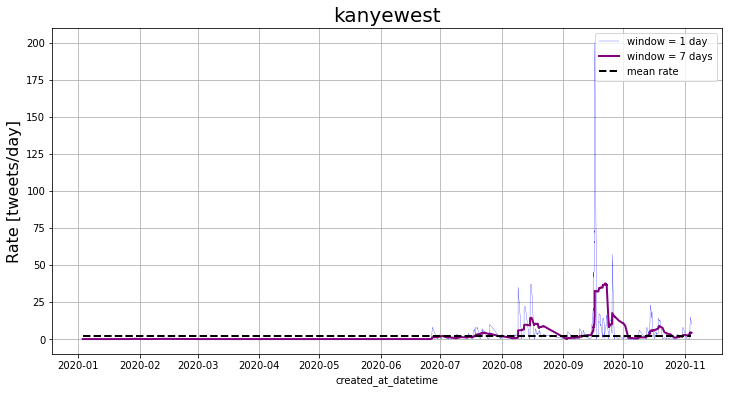

In [71]:
fig = plt.figure(figsize = (12,6))
sns.lineplot(data = df, x = 'created_at_datetime',y = 'rate_1D',label = 'window = 1 day',linewidth = .25,color = 'blue')
sns.lineplot(data = df, x = 'created_at_datetime',y = 'rate_7D',label = 'window = 7 days', linewidth = 2,color = 'purple')

plt.plot(df.created_at_datetime.tolist(),rate_estimate*np.ones(len(df)),label = 'mean rate',linestyle = '--',linewidth = 2,color = 'black')

plt.grid()
plt.ylabel("Rate [tweets/day]",fontsize = 16)
#plt.xlim(datetime.date(2021, 1, 1),datetime.date(2022,1,1))
#plt.ylim([0,30])
plt.title(f"{screen_name}",fontsize = 20)

plt.legend()
plt.show()

## Tweets During Peak Tweet Rate

Let's find the datetime when the tweet rate with a 1 day window is maximal and call this value `tpeak`.  We do this with the logical condition `df.rate_1D==df.rate_1D.max()`, and then getting the value in the `created_at_datetime` column.

In [72]:
tpeak = df[df.rate_1D==df.rate_1D.max()].created_at_datetime.values[0]
print(f"Peak tweet rate on {tpeak}")


Peak tweet rate on 2020-09-16T17:39:39.000000000


## Peak Rate Tweets

We can make a dataframe of the tweets within a 24 hour window ending at `tpeak`.  We specify `t0` and `t1` as the start and stop stime for the window.  Then we use the logical condition  `(df.created_at_datetime>=t0) & (df.created_at_datetime<t1)` to get all tweets in this window and call the resulting dataframe `df1`.



In [73]:
t0 = tpeak - np.timedelta64(24, 'h')
t1 = tpeak 
df1 = df[(df.created_at_datetime>=t0) & (df.created_at_datetime<t1)]

df1.head()


,screen_name,created_at,text,retweet_count,text_clean,created_at_datetime,created_at_datetime_ny,tweet_indicator,rate_1D,rate_7D
748,kanyewest,2020-09-15T18:24:37.000Z,SAY YES!!! We need to produce that Destiny’s C...,2623,say yes we need to produce that destinys child...,2020-09-15 18:24:37,2020-09-15 14:24:37,1.0,17.0,5.142857
747,kanyewest,2020-09-15T20:35:39.000Z,We need Me J Cole Drake Kendrick all in a room...,15971,we need me j cole drake kendrick all in a room...,2020-09-15 20:35:39,2020-09-15 16:35:39,1.0,18.0,5.285714
746,kanyewest,2020-09-15T20:55:08.000Z,Jared Kushner will have done more for peace in...,7641,jared kushner will have done more for peace in...,2020-09-15 20:55:08,2020-09-15 16:55:08,1.0,19.0,5.428571
745,kanyewest,2020-09-15T21:12:56.000Z,When I spoke to Katie Jacobs who is on the boa...,2334,when i spoke to katie jacobs who is on the boa...,2020-09-15 21:12:56,2020-09-15 17:12:56,1.0,20.0,5.571429
744,kanyewest,2020-09-16T00:01:54.000Z,The Y Combinator started companies like Dropbo...,1828,the y combinator started companies like dropbo...,2020-09-16 00:01:54,2020-09-15 20:01:54,1.0,21.0,5.428571


## Word Cloud of Peak Tweets

We can make a wordcloud of the peak rate tweets to understand what was driving the increased activity that day.

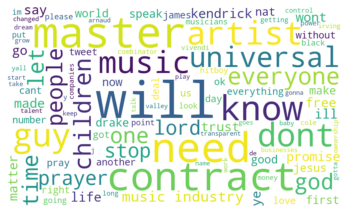

In [74]:
stopwords = set(STOPWORDS)
text=' '.join(df1.text_clean.tolist()).lower()
wordcloud = WordCloud(stopwords=stopwords,max_font_size=150, max_words=100, background_color="white",width=1000, height=600)
wordcloud.generate(text)

fig = plt.figure(figsize = (6,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Rolling Average of Retweet Count

We can use the `rolling` function to plot rolling averages of numerical quantities like `retweet_count`.  We just apply the `mean` function.  

In [75]:
df['retweet_count_1D'] = df.rolling('1D',on = 'created_at_datetime').mean()['retweet_count']
df['retweet_count_7D'] = df.rolling('7D',on = 'created_at_datetime').mean()['retweet_count']


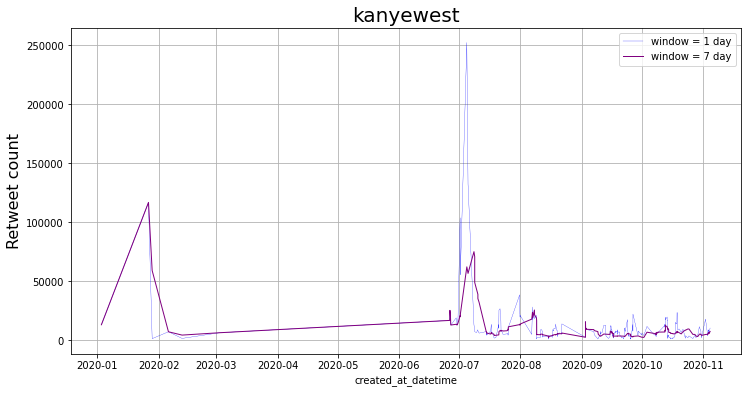

In [76]:
fig = plt.figure(figsize = (12,6))
sns.lineplot(data = df, x = 'created_at_datetime',y = 'retweet_count_1D',label = 'window = 1 day',
             linewidth = .25,color = 'blue')
sns.lineplot(data = df, x = 'created_at_datetime',y = 'retweet_count_7D',label = 'window = 7 day',
             linewidth = 1,color = 'purple')


plt.grid()
plt.ylabel("Retweet count",fontsize = 16)
#plt.xlim(datetime.date(2014, 1, 1),datetime.date(2021,1,1))
#plt.ylim([0,1e5])
plt.legend()
plt.title(f"{screen_name}",fontsize = 20)
plt.show()

##  Histogram of Tweet Day of the Week
Create a column in the dataframe called `day` which has the day of the week of each tweet.  We get the day of the week of a tweet with the `dt.day_name()` function.  

We can then make a histogram of the day of the user's tweets. 

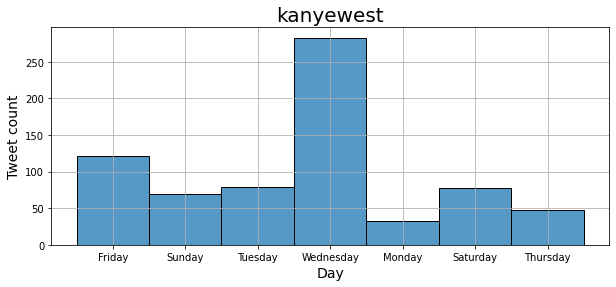

In [77]:
df['day'] = df.created_at_datetime.dt.day_name()   #get the day of the tweet

fig = plt.figure(figsize = (10,4))
sns.histplot(data = df, x = 'day')
plt.title(f"{screen_name}",fontsize = 20)
plt.ylabel("Tweet count",fontsize = 14)
plt.xlabel("Day",fontsize = 14)
plt.grid()
plt.show()

##  Tweet Hour Histograms

Create a column `hour` with the hour of the tweets.  We can obtain the hour of a tweet with the `hour` parameter on the `datetime_created_at` column.  Note that the hours will be in UTC.

Then we can make a histogram of the hour of each tweet for each user in the dataframe.  We will force the histogram to have have 24 bins going from 0 to 23 with the `bins` variable and the `bins` parameter in this `histplot` function.


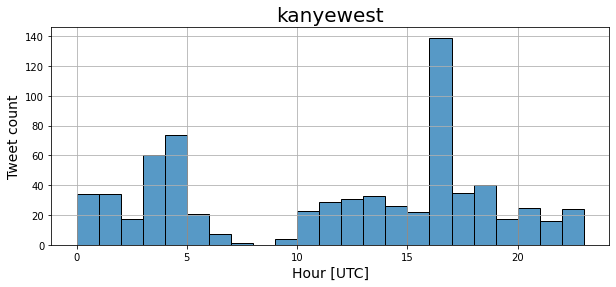

In [78]:
df['hour'] = df.created_at_datetime.dt.hour   #get the day of the tweet

bins = list(range(0,24))


fig = plt.figure(figsize = (10,4))
sns.histplot(data = df, x = 'hour',bins = bins)
plt.title(f"{screen_name}",fontsize = 20)
plt.ylabel("Tweet count",fontsize = 14)
plt.xlabel("Hour [UTC]",fontsize = 14)
plt.grid()
plt.show()

## Tweets During a Specific Hour or Day

We can get the tweets posted during a specific hour (i.e. 10 AM) or day of the week (i.e. Monday) using simple logical conditions applied to the `day` and `hour` columns.

In [79]:
df_hour = df[df.hour==10]
df_hour.head()

,screen_name,created_at,text,retweet_count,text_clean,created_at_datetime,created_at_datetime_ny,tweet_indicator,rate_1D,rate_7D,retweet_count_1D,retweet_count_7D,day,hour
1002,kanyewest,2020-06-26T10:27:29.000Z,#WESTDAYEVER https://t.co/ASMwbx7T2o,16776,westdayever,2020-06-26 10:27:29,2020-06-26 06:27:29,1.0,0.0,0.000000,16776.000000,16776.000000,Friday,10
471,kanyewest,2020-09-25T10:00:08.000Z,⛷ https://t.co/6rQJDcf3jN,3426,,2020-09-25 10:00:08,2020-09-25 06:00:08,1.0,7.0,10.428571,2241.000000,4927.270270,Friday,10
470,kanyewest,2020-09-25T10:01:51.000Z,David Koma I liked this collection a lot ...,206,david koma i liked this collection a lot,2020-09-25 10:01:51,2020-09-25 06:01:51,1.0,8.0,10.571429,2014.888889,4864.320000,Friday,10
469,kanyewest,2020-09-25T10:02:00.000Z,https://t.co/Ivs7uBVLL6,197,,2020-09-25 10:02:00,2020-09-25 06:02:00,1.0,9.0,10.714286,1833.100000,4802.907895,Friday,10
468,kanyewest,2020-09-25T10:02:58.000Z,Bianca Saunders https://t.co/UvvaPyIMuT,204,bianca saunders,2020-09-25 10:02:58,2020-09-25 06:02:58,1.0,10.0,10.857143,1685.000000,4743.181818,Friday,10


In [80]:
day = 'Wednesday'
df_day = df[df.day==day]
df_day.head()

,screen_name,created_at,text,retweet_count,text_clean,created_at_datetime,created_at_datetime_ny,tweet_indicator,rate_1D,rate_7D,retweet_count_1D,retweet_count_7D,day,hour
1005,kanyewest,2020-02-05T23:15:06.000Z,Family https://t.co/vVQO68atHr,7140,family,2020-02-05 23:15:06,2020-02-05 19:15:06,1.0,0.0,0.000000,7140.0,7140.000000,Wednesday,23
1004,kanyewest,2020-02-12T19:35:24.000Z,Sunday Service Experience\n\nCredit Union 1 Ar...,1519,sunday service experiencecredit union 1 arena ...,2020-02-12 19:35:24,2020-02-12 15:35:24,1.0,0.0,0.142857,1519.0,4329.500000,Wednesday,19
989,kanyewest,2020-07-01T15:44:25.000Z,When you go to your boys house and you’re both...,103764,when you go to your boys house and youre both ...,2020-07-01 15:44:25,2020-07-01 11:44:25,1.0,0.0,1.857143,103764.0,20847.142857,Wednesday,15
988,kanyewest,2020-07-01T18:22:06.000Z,new joint w ty https://t.co/E95eZMWJki,7248,new joint w ty,2020-07-01 18:22:06,2020-07-01 14:22:06,1.0,1.0,2.000000,55506.0,19940.533333,Wednesday,18
987,kanyewest,2020-07-01T19:21:31.000Z,https://t.co/PfQENqgGou https://t.co/wJLvIufr2u,61920,,2020-07-01 19:21:31,2020-07-01 15:21:31,1.0,2.0,2.142857,57644.0,22564.250000,Wednesday,19


## Word Cloud of Tweets on a Specific Hour or Day

Once you create a dataframe with tweets from a specific time period, hour, or day, you can easily make a word cloud of them.

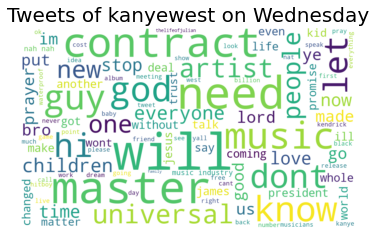

In [81]:
stopwords = set(STOPWORDS)
stopwords.add(screen_name)
text=' '.join(df_day.text_clean.tolist()).lower()
wordcloud = WordCloud(stopwords=stopwords,max_font_size=150, max_words=100, background_color="white",width=1000, height=600)
wordcloud.generate(text)

fig = plt.figure(figsize = (6,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title(f"Tweets of {screen_name} on {day}",fontsize = 20)

plt.show()

# Geo-location with Tweet Times 

Now we will try to figure out what time zone people are based on when their Twitter activity is low.

##  Tweet Hour Histograms

Let's begin by making a histogram of the hour of each tweet for each user in the dataframe. We will specify the number of bins, as we did before.



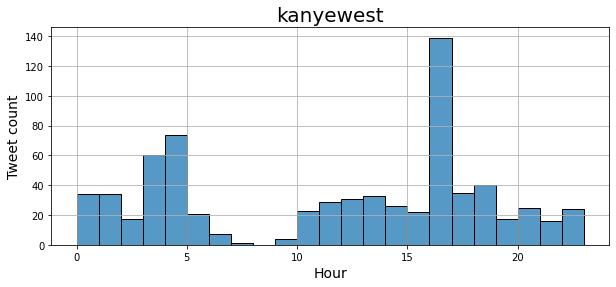

In [82]:
bins = list(range(0,24))

for screen_name in df.screen_name.unique():
    df1 = df[df.screen_name==screen_name]
    fig = plt.figure(figsize = (10,4))
    sns.histplot(data = df1, x = 'hour',bins = bins)
    plt.title(f"{screen_name}",fontsize = 20)

    plt.ylabel("Tweet count",fontsize = 14)
    plt.xlabel("Hour",fontsize = 14)
    plt.grid()
    plt.show()  

## Function to Find UTC Offset based on High Low Model

The function `geolocate_utc_offset` takes as input a dataframe of tweets `df` and a list of hours when activity is low, `low_hours` and returns the UTC offset that puts the fewest number of tweets in the low activity period.  You need a column `hour` in the dataframe that has the hour of each tweet.  

`geolocate_utc_offset` returns three things:

1. `utc_offset_min` = UTC offset to put fewest tweets in `low_hours`

2. `nlows` = list of number of tweets during `low_hours` for each possible UTC offset

3. `utc_offsets` = list of possible UTC offsets

In [83]:
def geolocate_utc_offset(df,low_hours):
    nlows = []
    utc_offsets = list(range(-11,13))
    for utc_offset in utc_offsets:
        low_hours_offset = [(h-utc_offset)%24 for h in low_hours]
        nlow = len(df1[df1.hour.isin(low_hours_offset)])
        nlows.append(nlow)
    utc_offset_min = utc_offsets[nlows.index(min(nlows))]
    return utc_offset_min,nlows,utc_offsets

## Find UTC Offset

We specify `low_hours` as a list of hours when we think activity is low.  Then a `for` loop goes through each screen name and finds their UTC offset.  This `for` loop might come in handy on your homework :)

To see possible cities in the time zone corresponding to the UTC offset, use this link:

https://www.timeanddate.com/time/map/

In [84]:
low_hours = [4,5]  #hours when activity is low in local time zone 
for screen_name in df.screen_name.unique():
    df1 = df[df.screen_name==screen_name]
    utc_offset_min,nlows,utc_offsets = geolocate_utc_offset(df1,low_hours)
    print(f"{screen_name}: UTC offset = {utc_offset_min}")

kanyewest: UTC offset = -3
